# Reusable Embeddings

**Learning Objectives**
1. Learn how to use a pre-trained TF Hub text modules to generate sentence vectors.
1. Learn how to incorporate a pre-trained TF-Hub module into a Keras model.


## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = "qwiklabs-gcp-00-bab8718fd0ad"  # Replace with your PROJECT
BUCKET = PROJECT 
REGION = "europe-west4"  

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [4]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,url,title,score
0,https://www.bloomberg.com/news/articles/2022-0...,Quant Theorists Are Paid to Delude Themselves,11
1,http://www.ewanleith.com/blog/472/google-turns...,Google turns inwards,11
2,https://electrek.co/2022/06/20/tesla-lay-off-h...,Tesla lays off head of LGBTQ+ and diversity le...,11
3,http://www.amazon.com/,"Amazon adds 800 TV Shows, Disney-ABC to Prime ...",11
4,https://lite.cnn.com/en/article/h_f95169106878...,Wind and solar power are 'bailing out' Texas a...,11
5,https://www.theregister.com/2022/06/22/amazon_...,Amazon shows off robot warehouse workers that ...,11
6,https://www.cnn.com/2022/06/19/tech/apple-stor...,Union wins right to represent workers at an Ap...,11
7,https://www.reuters.com/world/europe/wikipedia...,Wikipedia fights Russian order to remove Ukrai...,11
8,https://www.newyorker.com/magazine/2022/06/20/...,Yoko Ono’s Art of Defiance,11
9,https://www.modos.tech/blog/modos-paper-monitor,The Modos Paper Monitor,11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [5]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source,num_articles
0,github,165690
1,medium,131782
2,youtube,119462
3,nytimes,80917
4,blogspot,61382
...,...,...
95,thehackernews,2984
96,nextplatform,2982
97,atlasobscura,2981
98,smithsonianmag,2961


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,otto.de open source projects,github
1,show hn flighty a simple structural css fra...,github
2,show hn dot a dotfile synchronisation script,github
3,template prefetching for angularjs with ui-router,github
4,show hn php psr7 http implementation package,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [8]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 304365 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

github        165690
nytimes        80917
techcrunch     57758
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [10]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [11]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [12]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        542
nytimes       256
techcrunch    202
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [13]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [14]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.6.5


In [15]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [16]:
MODEL_DIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [17]:
ls ./data/

titles_full.csv  titles_sample.csv


In [18]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,kchat persistent group chat in 50 lines usin...,github
1,show hn headless ravencoin wallet using docke...,github
2,never thought redux can be so easy,github
3,sprint and google will announce a $12 billion...,nytimes
4,exploring image classification with multimodal...,github


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [19]:
titles_df.source.value_counts()

github        165690
nytimes        80917
techcrunch     57758
Name: source, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [20]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [21]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [22]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [23]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [24]:
sources_train.value_counts()

github        157430
nytimes        76895
techcrunch     54821
Name: source, dtype: int64

In [25]:
sources_valid.value_counts()

github        8260
nytimes       4022
techcrunch    2937
Name: source, dtype: int64

Now let's create the features and labels we will feed our models with:

In [26]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [27]:
X_train[:3]

array(['kchat  persistent group chat in  50 lines using kdb  k q web sockets  javascript',
       'show hn  headless ravencoin wallet using docker and novnc',
       'never thought redux can be so easy'], dtype=object)

In [28]:
Y_train[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

### Lab Task 1a: Import NNLM TF Hub module into `KerasLayer`

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [29]:
# TODO 1
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True)

2024-07-19 18:16:04.347717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-07-19 18:16:04.347762: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-19 18:16:04.347794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240719-120823): /proc/driver/nvidia/version does not exist
2024-07-19 18:16:04.348171: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
20

Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

### Lab Task 1b: Use module to encode a sentence string

In [30]:
# TODO 1
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

### Lab Task 1c: Import Swivel TF Hub module into `KerasLayer`

In [31]:
# TODO 1
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

### Lab Task 1d: Use module to encode a sentence string

In [32]:
# TODO 1
swivel_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.9967701 , -0.3100155 ,  0.5889897 , -0.16765082, -0.6171738 ,
        -1.1586996 , -0.8619045 ,  0.7281645 ,  0.32575002,  0.4754492 ,
        -0.9272241 ,  0.41090095, -0.75389475, -0.31525993, -1.8918804 ,
         0.6423996 ,  0.6801622 , -0.1335669 , -1.0017993 , -0.11908641]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

### Lab Task 2: Incorporate a pre-trained TF Hub module as first layer of Keras Sequential Model

In [33]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module, # TODO
        Dense(16, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [34]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=TensorBoard(model_dir),
    )
    return history

## Training NNLM

In [35]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [36]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

2024-07-19 18:17:32.977165: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-07-19 18:17:32.977220: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-07-19 18:17:32.980140: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/50
 1/58 [..............................] - ETA: 54s - loss: 1.1317 - accuracy: 0.2346

2024-07-19 18:17:34.080747: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-07-19 18:17:34.080793: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/58 [>.............................] - ETA: 25s - loss: 1.1273 - accuracy: 0.2476

2024-07-19 18:17:34.511567: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-07-19 18:17:34.514343: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-07-19 18:17:34.523733: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/nnlm/train/plugins/profile/2024_07_19_18_17_34

2024-07-19 18:17:34.525148: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/nnlm/train/plugins/profile/2024_07_19_18_17_34/instance-20240719-120823.trace.json.gz
2024-07-19 18:17:34.538383: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/nnlm/train/plugins/profile/2024_07_19_18_17_34

2024-07-19 18:17:34.538614: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./text_models/nnlm/train/plugins/profile/2024_07_19_18_17_

58/58 [==============================] - 26s 435ms/step - loss: 0.9485 - accuracy: 0.6227 - val_loss: 0.7055 - val_accuracy: 0.7691
Epoch 2/50
58/58 [==============================] - 26s 454ms/step - loss: 0.5126 - accuracy: 0.8255 - val_loss: 0.3850 - val_accuracy: 0.8578
Epoch 3/50
58/58 [==============================] - 25s 439ms/step - loss: 0.3255 - accuracy: 0.8780 - val_loss: 0.3079 - val_accuracy: 0.8801
Epoch 4/50
58/58 [==============================] - 26s 443ms/step - loss: 0.2672 - accuracy: 0.8988 - val_loss: 0.2830 - val_accuracy: 0.8892
Epoch 5/50
58/58 [==============================] - 25s 431ms/step - loss: 0.2379 - accuracy: 0.9100 - val_loss: 0.2725 - val_accuracy: 0.8921
Epoch 6/50
58/58 [==============================] - 26s 441ms/step - loss: 0.2189 - accuracy: 0.9175 - val_loss: 0.2687 - val_accuracy: 0.8957
Epoch 7/50
58/58 [==============================] - 26s 447ms/step - loss: 0.2050 - accuracy: 0.9231 - val_loss: 0.2687 - val_accuracy: 0.8955
Epoch 8/50

<AxesSubplot: >

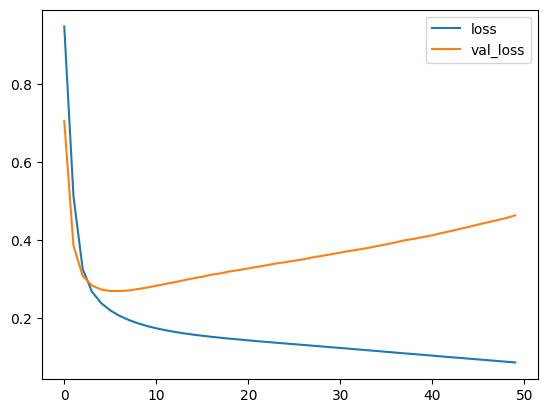

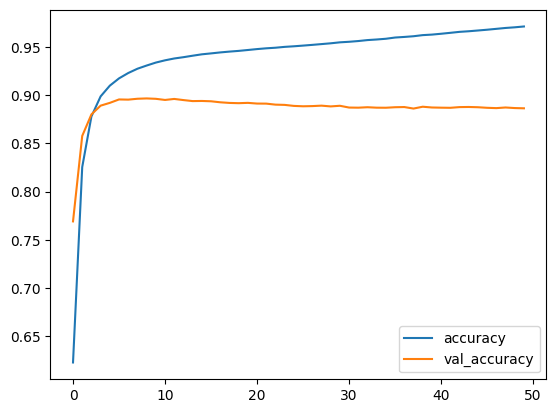

In [37]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Training Swivel

In [38]:
swivel_model = build_model(swivel_module, name='swivel')

In [39]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

2024-07-19 18:39:08.580647: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-07-19 18:39:08.580720: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-07-19 18:39:08.580928: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/50
 9/58 [===>..........................] - ETA: 1s - loss: 1.3060 - accuracy: 0.2804

2024-07-19 18:39:09.120603: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-07-19 18:39:09.120647: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-07-19 18:39:09.170738: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-07-19 18:39:09.171816: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-07-19 18:39:09.173653: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/swivel/train/plugins/profile/2024_07_19_18_39_09

2024-07-19 18:39:09.174637: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/swivel/train/plugins/profile/2024_07_19_18_39_09/instance-20240719-120823.trace.json.gz
2024-07-19 18:39:09.176155: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/swivel/train/plugin

58/58 [==============================] - 2s 24ms/step - loss: 1.0480 - accuracy: 0.4808 - val_loss: 0.8493 - val_accuracy: 0.6403
Epoch 2/50
58/58 [==============================] - 1s 20ms/step - loss: 0.7664 - accuracy: 0.6746 - val_loss: 0.6878 - val_accuracy: 0.7135
Epoch 3/50
58/58 [==============================] - 1s 20ms/step - loss: 0.6251 - accuracy: 0.7419 - val_loss: 0.5669 - val_accuracy: 0.7691
Epoch 4/50
58/58 [==============================] - 1s 20ms/step - loss: 0.5241 - accuracy: 0.7864 - val_loss: 0.4890 - val_accuracy: 0.8019
Epoch 5/50
58/58 [==============================] - 1s 20ms/step - loss: 0.4618 - accuracy: 0.8117 - val_loss: 0.4438 - val_accuracy: 0.8196
Epoch 6/50
58/58 [==============================] - 1s 21ms/step - loss: 0.4229 - accuracy: 0.8285 - val_loss: 0.4159 - val_accuracy: 0.8337
Epoch 7/50
58/58 [==============================] - 1s 20ms/step - loss: 0.3962 - accuracy: 0.8400 - val_loss: 0.3965 - val_accuracy: 0.8400
Epoch 8/50
58/58 [======

<AxesSubplot: >

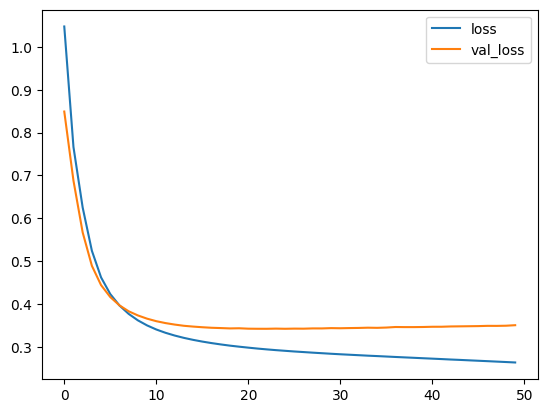

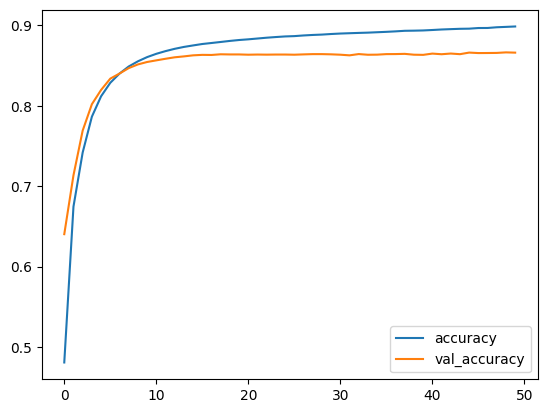

In [40]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2023 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License